In [33]:
# Importing the important packages
import tensorflow as tf
import keras
import matplotlib as plt
import numpy as np


In [34]:
from sklearn.model_selection import KFold

In [35]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [36]:
# Include the data.
import os
from PIL import Image
import cv2


In [37]:


# A function to load all the images from a certain folder
def load_images_from_folder(folder,type):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename),color_mode='grayscale',target_size=[360,180,1],interpolation='bilinear')
            # summarize some details about the image
            if img is not None:
                # I changed this part manually for loading the Cancer and Normal Images
                images.append((img,type))

    return images

In [38]:
# Load all the images from the files
Normal_Images = load_images_from_folder("/kaggle/input/dataset/Normal_generated",0)


In [39]:
np.shape(Normal_Images[0][0])

(360, 180)

In [40]:
# Preparing Both datasets with labels and shuffling them
Precancer_Images = load_images_from_folder("/kaggle/input/dataset/Precancer_generated",1)

# Preparing the datasets

In [41]:
# We will add the two lists to each other generating one combined list of all the examples
print("The length of Normal Images is {} and the length of Precancer Images list is {}".format(len(Normal_Images),len(Precancer_Images)))

The length of Normal Images is 125 and the length of Precancer Images list is 72


In [42]:
Images = Normal_Images+Precancer_Images
print("The length of the combined set of images is {}".format(len(Images)))


The length of the combined set of images is 197


In [43]:
import random as rand
# Shuffling the images to mix the precancer and normal Images
rand.shuffle(Images)

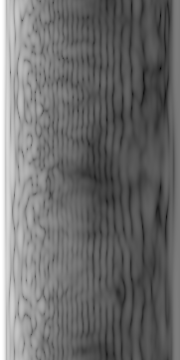

In [44]:
Normal_Images[0][0]

# Start of Data Augmentation Using GANS

In [45]:
# Data Augmentation using GANs
# source:  https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391
# source: tensorflow

In [46]:

BUFFER_SIZE = 60000
BATCH_SIZE = 8

"""_summary_
new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] + output_padding[0])
new_cols = ((cols - 1) * strides[1] + kernel_size[1] - 2 * padding[1] + output_padding[1])
"""

IMAGE_SIZE = (360, 180)

def make_generator_model():
    model = tf.keras.Sequential(name = 'Generator')
    model.add(layers.Dense(90*45*128, use_bias=False, input_shape=(200,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((90, 45, 128)))
    assert model.output_shape == (None, 90, 45, 128)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(filters = 64,kernel_size = (5, 5), strides=(2, 2), padding='same', use_bias=False)) 
    assert model.output_shape == (None, 180, 90, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filters = 1,kernel_size = (5, 5), strides=(2, 2), padding='same', use_bias=False)) 
    assert model.output_shape == (None, 360, 180, 1)  # Note: None is the batch size
        
    return model



(1, 360, 180, 1)


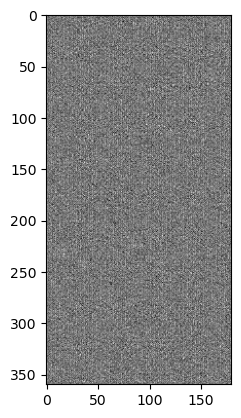

In [47]:
generator = make_generator_model()

noise = tf.random.normal([1, 200])
generated_image = generator(noise,training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [48]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [49]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='Discriminator')
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(360, 180, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=120, activation='relu'))
    model.add(tf.keras.layers.Dense(units=84, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    return model

In [50]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5008626]], shape=(1, 1), dtype=float32)


In [51]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [53]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [55]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [56]:
EPOCHS = 350
noise_dim = 200
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [57]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [58]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  if epoch %50 == 0:
    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

In [59]:
import time
def train(dataset, epochs):
  for epoch in range(epochs):
    print('Training Epoch #', epoch)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [60]:
X_train = []
y_train = []

for i in range(len(Normal_Images)):
    img = np.asarray(Normal_Images[i][0],dtype="uint8")
    X_train.append(img)
    y_train.append(Normal_Images[i][1])

X_train = np.asarray(X_train)
X_train = [x.reshape((1,360, 180, 1)) for x in X_train]


Training Epoch # 0
Time for epoch 1 is 9.709874629974365 sec
Training Epoch # 1
Time for epoch 18 is 6.133719444274902 sec
Training Epoch # 18
Time for epoch 19 is 6.135098218917847 sec
Training Epoch # 19
Time for epoch 20 is 6.134277820587158 sec
Training Epoch # 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Time for epoch 21 is 6.146646499633789 sec
Training Epoch # 21
Time for epoch 22 is 6.128483772277832 sec
Training Epoch # 22
Time for epoch 23 is 6.129655838012695 sec
Training Epoch # 23
Time for epoch 24 is 6.123979568481445 sec
Training Epoch # 24
Time for epoch 25 is 6.117290735244751 sec
Training Epoch # 25
Time for epoch 26 is 6.129940748214722 sec
Training Epoch # 26
Time for epoch 47 is 6.14837646484375 sec
Training Epoch # 47
Time for epoch 48 is 6.125676393508911 sec
Training Epoch # 48
Time for epoch 49 is 6.12563157081604 sec
Training Epoch # 49


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

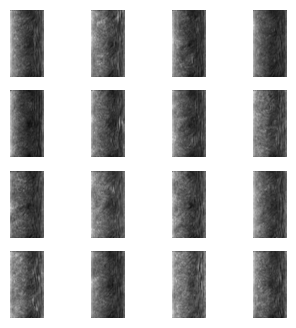

Time for epoch 50 is 10.776958465576172 sec
Training Epoch # 50
Time for epoch 51 is 6.167334079742432 sec
Training Epoch # 51
Time for epoch 52 is 6.135683059692383 sec
Training Epoch # 52
Time for epoch 53 is 6.131061792373657 sec
Training Epoch # 53
Time for epoch 54 is 6.148105621337891 sec
Training Epoch # 54
Time for epoch 55 is 6.14801549911499 sec
Training Epoch # 55
Time for epoch 56 is 6.135767459869385 sec
Training Epoch # 56
Time for epoch 57 is 6.145573854446411 sec
Training Epoch # 57
Time for epoch 58 is 6.1238250732421875 sec
Training Epoch # 58
Time for epoch 59 is 6.129682302474976 sec
Training Epoch # 59
Time for epoch 60 is 6.123326301574707 sec
Training Epoch # 60
Time for epoch 61 is 6.121973991394043 sec
Training Epoch # 61
Time for epoch 62 is 6.129315614700317 sec
Training Epoch # 62
Time for epoch 63 is 6.120865821838379 sec
Training Epoch # 63
Time for epoch 64 is 6.12921667098999 sec
Training Epoch # 64
Time for epoch 65 is 6.12906551361084 sec
Training Epoc

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

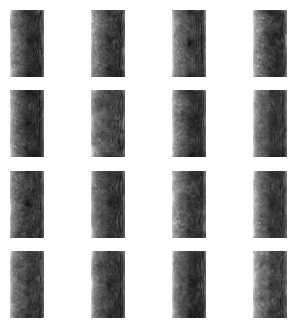

Time for epoch 100 is 10.580257892608643 sec
Training Epoch # 100
Time for epoch 101 is 6.16772723197937 sec
Training Epoch # 101
Time for epoch 102 is 6.146562576293945 sec
Training Epoch # 102
Time for epoch 103 is 6.137294054031372 sec
Training Epoch # 103
Time for epoch 104 is 6.153738737106323 sec
Training Epoch # 104
Time for epoch 105 is 6.156964302062988 sec
Training Epoch # 105
Time for epoch 106 is 6.152614593505859 sec
Training Epoch # 106
Time for epoch 107 is 6.156605243682861 sec
Training Epoch # 107
Time for epoch 108 is 6.138549327850342 sec
Training Epoch # 108
Time for epoch 109 is 6.1322925090789795 sec
Training Epoch # 109
Time for epoch 110 is 6.1269800662994385 sec
Training Epoch # 110
Time for epoch 111 is 6.111562013626099 sec
Training Epoch # 111
Time for epoch 112 is 6.140469551086426 sec
Training Epoch # 112
Time for epoch 113 is 6.1175947189331055 sec
Training Epoch # 113
Time for epoch 114 is 6.123496770858765 sec
Training Epoch # 114
Time for epoch 115 is 

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

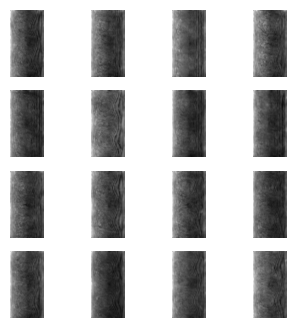

Time for epoch 150 is 10.490304231643677 sec
Training Epoch # 150
Time for epoch 151 is 6.177664041519165 sec
Training Epoch # 151
Time for epoch 152 is 6.114171743392944 sec
Training Epoch # 152
Time for epoch 153 is 6.145882844924927 sec
Training Epoch # 153
Time for epoch 154 is 6.144615411758423 sec
Training Epoch # 154
Time for epoch 155 is 6.143050193786621 sec
Training Epoch # 155
Time for epoch 156 is 6.1377012729644775 sec
Training Epoch # 156
Time for epoch 157 is 6.136189699172974 sec
Training Epoch # 157
Time for epoch 158 is 6.142947196960449 sec
Training Epoch # 158
Time for epoch 159 is 6.1225950717926025 sec
Training Epoch # 159
Time for epoch 160 is 6.118370532989502 sec
Training Epoch # 160
Time for epoch 161 is 6.118763446807861 sec
Training Epoch # 161
Time for epoch 162 is 6.1159727573394775 sec
Training Epoch # 162
Time for epoch 163 is 6.1288063526153564 sec
Training Epoch # 163
Time for epoch 164 is 6.12263560295105 sec
Training Epoch # 164
Time for epoch 165 is

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

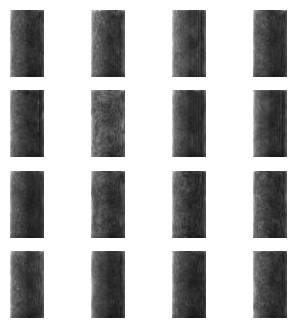

Time for epoch 200 is 10.896894931793213 sec
Training Epoch # 200
Time for epoch 201 is 6.145998477935791 sec
Training Epoch # 201
Time for epoch 202 is 6.112714767456055 sec
Training Epoch # 202
Time for epoch 203 is 6.124835014343262 sec
Training Epoch # 203
Time for epoch 204 is 6.15981650352478 sec
Training Epoch # 204
Time for epoch 205 is 6.1523756980896 sec
Training Epoch # 205
Time for epoch 206 is 6.144655704498291 sec
Training Epoch # 206
Time for epoch 207 is 6.134612083435059 sec
Training Epoch # 207
Time for epoch 208 is 6.127012252807617 sec
Training Epoch # 208
Time for epoch 209 is 6.139972686767578 sec
Training Epoch # 209
Time for epoch 210 is 6.113168954849243 sec
Training Epoch # 210
Time for epoch 211 is 6.118394136428833 sec
Training Epoch # 211
Time for epoch 212 is 6.111541271209717 sec
Training Epoch # 212
Time for epoch 213 is 6.1131651401519775 sec
Training Epoch # 213
Time for epoch 214 is 6.119041919708252 sec
Training Epoch # 214
Time for epoch 215 is 6.11

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

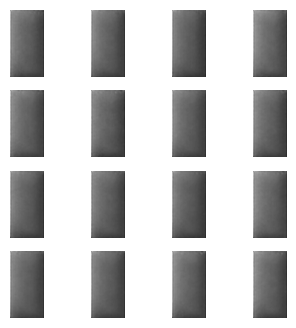

Time for epoch 250 is 10.638256788253784 sec
Training Epoch # 250
Time for epoch 251 is 6.145190477371216 sec
Training Epoch # 251
Time for epoch 252 is 6.111695289611816 sec
Training Epoch # 252
Time for epoch 253 is 6.124466896057129 sec
Training Epoch # 253
Time for epoch 254 is 6.139947414398193 sec
Training Epoch # 254
Time for epoch 255 is 6.148526191711426 sec
Training Epoch # 255
Time for epoch 256 is 6.13049840927124 sec
Training Epoch # 256
Time for epoch 257 is 6.126953840255737 sec
Training Epoch # 257
Time for epoch 258 is 6.120794057846069 sec
Training Epoch # 258
Time for epoch 259 is 6.1157026290893555 sec
Training Epoch # 259
Time for epoch 260 is 6.121781349182129 sec
Training Epoch # 260
Time for epoch 261 is 6.1107025146484375 sec
Training Epoch # 261
Time for epoch 262 is 6.107376337051392 sec
Training Epoch # 262
Time for epoch 263 is 6.104236125946045 sec
Training Epoch # 263
Time for epoch 264 is 6.115830183029175 sec
Training Epoch # 264
Time for epoch 265 is 6

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

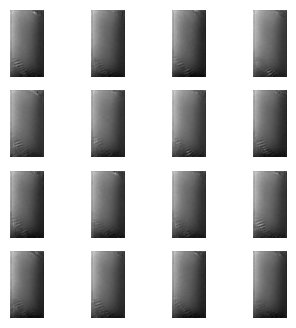

Time for epoch 300 is 11.319592475891113 sec
Training Epoch # 300
Time for epoch 301 is 6.1546790599823 sec
Training Epoch # 301
Time for epoch 302 is 6.143082857131958 sec
Training Epoch # 302
Time for epoch 303 is 6.134970664978027 sec
Training Epoch # 303
Time for epoch 304 is 6.150758981704712 sec
Training Epoch # 304
Time for epoch 305 is 6.1628029346466064 sec
Training Epoch # 305
Time for epoch 306 is 6.141261100769043 sec
Training Epoch # 306
Time for epoch 307 is 6.134583234786987 sec
Training Epoch # 307
Time for epoch 308 is 6.12101411819458 sec
Training Epoch # 308
Time for epoch 309 is 6.122051954269409 sec
Training Epoch # 309
Time for epoch 310 is 6.118988752365112 sec
Training Epoch # 310
Time for epoch 311 is 6.119580030441284 sec
Training Epoch # 311
Time for epoch 312 is 6.1179587841033936 sec
Training Epoch # 312
Time for epoch 313 is 6.117089748382568 sec
Training Epoch # 313
Time for epoch 314 is 6.119457960128784 sec
Training Epoch # 314
Time for epoch 315 is 6.1

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

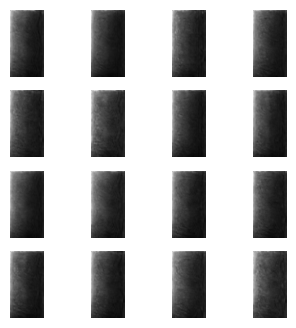

Time for epoch 350 is 10.930596828460693 sec


AttributeError: 'function' object has no attribute 'clear_output'

In [61]:
train(X_train, EPOCHS)


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)


In [ ]:
noise = tf.random.normal([1, 200])
generated_image = generator(noise,training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')